# Confounder analysis for the multi-center RPN-signature
- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/5_confounder_analysis.ipynb
- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature
- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3
- Raw data from center 3 is available upon reasonable request.

## Imports

In [4]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from mlxtend.evaluate import permutation_test

from mlconfound.stats import partial_confound_test

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature

## Load and merge behavioral data for all three centers (after exclusions)

In [5]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()

### correct for different questionnaire evaluation in the Essen-sample
df.loc[df.study=='essen', 'psq'] *= 20 
df.loc[df.study=='essen', 'anx_state'] *= 20 
df.loc[df.study=='essen', 'anx_trait'] *= 20 

### negate the log mean mechanical detection threshold in center 3 (is already negated in center 2 and is not available in center 1)
df.loc[df.study=='szeged', 'MDT_log_geom'] *= -1 

df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,1.145363,78.0,89.0,7.0,37.0


## Load predictions newly proposed multi-center model

In [6]:
multicener_predictions = np.genfromtxt('../res/multi-center/nested_cv_combat_conservative_pred_full_GroupKFold30.csv', delimiter=',')


## Test association with the confounder variables

In [7]:
for varname in ['meanFD', 'maxFD', 'perc_scrubbed', 'BP_QST_sys', 'BP_QST_dias', 'BP_MRI_sys', 'BP_MRI_dias', 'MRI_QST_dif',
               'Age', 'Male', 'BMI', 'day_menses', 'alk_per_w', 'edu', 
               'pcs_catastrophizing', 'pcs_rumination', 'psq', 'BDI', 'ads_k', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', #psq: pain sensitivity; PSQ20. precieved stress
               'CDT_log_mean', 'WDT_log_mean','MDT_log_geom', 't50', 'GABA_mean', 'Glx_mean' ]:

    isnan = np.isnan(df[varname])
    confunder=df[varname][~isnan]
    
    p_corr_s1 = permutation_test(multicener_predictions[~isnan][df.study[~isnan]=='bochum'], confunder[df.study[~isnan]=='bochum'],
                               func=lambda x, y: np.abs(np.corrcoef(x, y)[0,1]),
                               method='approximate',
                               num_rounds=8000,
                               seed=42)

    
    corr_s1 = np.corrcoef(multicener_predictions[~isnan][df.study[~isnan]=='bochum'], confunder[df.study[~isnan]=='bochum'])[0,1]
    print(varname, '@center1     ', 'r =', np.round(corr_s1, 2), ' p =', np.round(p_corr_s1, 3))

    p_corr_s2 = permutation_test(multicener_predictions[~isnan][df.study[~isnan]=='essen'], confunder[df.study[~isnan]=='essen'],
                                   func=lambda x, y: np.abs(np.corrcoef(x, y)[0,1]),
                                   method='approximate',
                                   num_rounds=8000,
                                   seed=42)
    corr_s2 = np.corrcoef(multicener_predictions[~isnan][df.study[~isnan]=='essen'], confunder[df.study[~isnan]=='essen'])[0,1]
    print(varname, '@center2     ', 'r =', np.round(corr_s2, 2), ' p =', np.round(p_corr_s2, 3))

    p_corr_s3 = permutation_test(multicener_predictions[~isnan][df.study[~isnan]=='szeged'], confunder[df.study[~isnan]=='szeged'],
                                   func=lambda x, y: np.abs(np.corrcoef(x, y)[0,1]),
                                   method='approximate',
                                   num_rounds=8000,
                                   seed=42)
    corr_s3 = np.corrcoef(multicener_predictions[~isnan][df.study[~isnan]=='szeged'], confunder[df.study[~isnan]=='szeged'])[0,1]
    print(varname, '@center3     ', 'r =', np.round(corr_s3, 2), ' p =', np.round(p_corr_s3, 3))

    p_corr_s123 = permutation_test(multicener_predictions[~isnan], confunder,
                                   func=lambda x, y: np.abs(np.corrcoef(x, y)[0,1]),
                                   method='approximate',
                                   num_rounds=8000,
                                   seed=42)
    corr_s123 = np.corrcoef(multicener_predictions[~isnan], confunder)[0,1]
    print(varname, '@center1-2-3 ', 'r =', np.round(corr_s123, 2), ' p =', np.round(p_corr_s123, 3))
    print('--------------------------------------------------')


meanFD @center1      r = -0.08  p = 0.61
meanFD @center2      r = 0.02  p = 0.889
meanFD @center3      r = -0.07  p = 0.755
meanFD @center1-2-3  r = -0.06  p = 0.592
--------------------------------------------------
maxFD @center1      r = -0.05  p = 0.769
maxFD @center2      r = 0.22  p = 0.198
maxFD @center3      r = 0.11  p = 0.655
maxFD @center1-2-3  r = 0.12  p = 0.251
--------------------------------------------------
perc_scrubbed @center1      r = -0.04  p = 0.821
perc_scrubbed @center2      r = -0.09  p = 0.588
perc_scrubbed @center3      r = -0.07  p = 0.823
perc_scrubbed @center1-2-3  r = -0.06  p = 0.598
--------------------------------------------------


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


BP_QST_sys @center1      r = nan  p = 0.0
BP_QST_sys @center2      r = -0.15  p = 0.383
BP_QST_sys @center3      r = -0.06  p = 0.793
BP_QST_sys @center1-2-3  r = -0.12  p = 0.401
--------------------------------------------------
BP_QST_dias @center1      r = nan  p = 0.0
BP_QST_dias @center2      r = -0.24  p = 0.153
BP_QST_dias @center3      r = -0.4  p = 0.163
BP_QST_dias @center1-2-3  r = -0.27  p = 0.06
--------------------------------------------------
BP_MRI_sys @center1      r = nan  p = 0.0
BP_MRI_sys @center2      r = 0.01  p = 0.978
BP_MRI_sys @center3      r = 0.04  p = 0.902
BP_MRI_sys @center1-2-3  r = 0.04  p = 0.755
--------------------------------------------------
BP_MRI_dias @center1      r = nan  p = 0.0
BP_MRI_dias @center2      r = 0.3  p = 0.079
BP_MRI_dias @center3      r = -0.14  p = 0.518
BP_MRI_dias @center1-2-3  r = 0.22  p = 0.111
--------------------------------------------------


/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


MRI_QST_dif @center1      r = nan  p = 0.0
MRI_QST_dif @center2      r = 0.0  p = 0.979
MRI_QST_dif @center3      r = 0.2  p = 0.419
MRI_QST_dif @center1-2-3  r = 0.1  p = 0.293
--------------------------------------------------
Age @center1      r = -0.03  p = 0.88
Age @center2      r = -0.15  p = 0.379
Age @center3      r = 0.37  p = 0.114
Age @center1-2-3  r = -0.05  p = 0.654
--------------------------------------------------
Male @center1      r = -0.05  p = 0.774
Male @center2      r = 0.25  p = 0.136
Male @center3      r = 0.24  p = 0.333
Male @center1-2-3  r = 0.11  p = 0.313
--------------------------------------------------
BMI @center1      r = -0.13  p = 0.472
BMI @center2      r = -0.02  p = 0.897
BMI @center3      r = 0.19  p = 0.431
BMI @center1-2-3  r = -0.03  p = 0.787
--------------------------------------------------
day_menses @center1      r = 0.33  p = 0.348
day_menses @center2      r = -0.22  p = 0.368
day_menses @center3      r = -0.15  p = 0.694
day_menses @cen

## Plot significant associations

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='t50'>

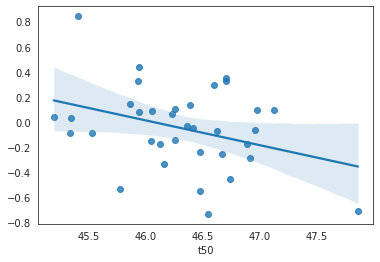

In [8]:
sns.regplot(df.t50, multicener_predictions)

/home/tspisak/src/RPN-signature/venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Glx_mean'>

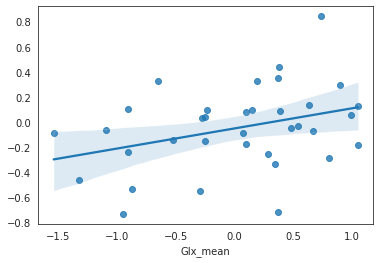

In [9]:
sns.regplot(df.Glx_mean, multicener_predictions)

In [21]:
# mlconfound


for varname in ['meanFD', 'maxFD', 'perc_scrubbed', 'BP_QST_sys', 'BP_QST_dias', 'BP_MRI_sys', 'BP_MRI_dias', 'MRI_QST_dif',
               'Age', 'Male', 'BMI', 'day_menses', 'alk_per_w', 'edu',
               'pcs_catastrophizing', 'pcs_rumination', 'psq', 'BDI', 'ads_k', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', #psq: pain sensitivity; PSQ20. precieved stress
               'CDT_log_mean', 'WDT_log_mean','MDT_log_geom', 't50', 'GABA_mean', 'Glx_mean' ]:

    isnan = np.isnan(df[varname])
    confunder=df[varname][~isnan]

    if len(df.mean_QST_pain_sensitivity[~isnan][df.study[~isnan]=='bochum'])>0 and confunder[df.study[~isnan]=='bochum'].std()>0:
        res=partial_confound_test(
            y=df.mean_QST_pain_sensitivity[~isnan][df.study[~isnan]=='bochum'],
            yhat=multicener_predictions[~isnan][df.study[~isnan]=='bochum'],
            c=confunder[df.study[~isnan]=='bochum'],
            progress=False, random_state=42
        )
        p_corr_s1 = res.p
        corr_s1 = res.r2_yhat_c
        print(varname, '@center1     ', 'r =', np.round(corr_s1, 2), ' p =', np.round(p_corr_s1, 3))

    if len(df.mean_QST_pain_sensitivity[~isnan][df.study[~isnan]=='essen'])>0:
        res=partial_confound_test(
            y=df.mean_QST_pain_sensitivity[~isnan][df.study[~isnan]=='essen'],
            yhat=multicener_predictions[~isnan][df.study[~isnan]=='essen'],
            c=confunder[df.study[~isnan]=='essen'],
            progress=False, random_state=42
        )
        p_corr_s2 = res.p
        corr_s2 = res.r2_yhat_c
        print(varname, '@center2     ', 'r =', np.round(corr_s2, 2), ' p =', np.round(p_corr_s2, 3))

    if len(df.mean_QST_pain_sensitivity[~isnan][df.study[~isnan]=='szeged'])>0:
        res=partial_confound_test(
            y=df.mean_QST_pain_sensitivity[~isnan][df.study[~isnan]=='szeged'],
            yhat=multicener_predictions[~isnan][df.study[~isnan]=='szeged'],
            c=confunder[df.study[~isnan]=='szeged'],
            progress=False, random_state=42
        )
        p_corr_s3 = res.p
        corr_s3 = res.r2_yhat_c
        print(varname, '@center3     ', 'r =', np.round(corr_s3, 2), ' p =', np.round(p_corr_s3, 3))


    if len(df.mean_QST_pain_sensitivity[~isnan])>0:
        res=partial_confound_test(
            y=df.mean_QST_pain_sensitivity[~isnan],
            yhat=multicener_predictions[~isnan],
            c=confunder,
            progress=False, random_state=42
        )
        p_corr_s123 = res.p
        corr_s123 = res.r2_yhat_c
        print(varname, '@center1-2-3 ', 'r =', np.round(corr_s123, 2), ' p =', np.round(p_corr_s123, 3))
    print('--------------------------------------------------')



meanFD @center1      r = 0.01  p = 0.655
meanFD @center2      r = 0.0  p = 0.94
meanFD @center3      r = 0.0  p = 0.781
meanFD @center1-2-3  r = 0.0  p = 0.644
--------------------------------------------------
maxFD @center1      r = 0.0  p = 0.775
maxFD @center2      r = 0.05  p = 0.386
maxFD @center3      r = 0.01  p = 0.658
maxFD @center1-2-3  r = 0.02  p = 0.249
--------------------------------------------------
perc_scrubbed @center1      r = 0.0  p = 0.829
perc_scrubbed @center2      r = 0.01  p = 0.674
perc_scrubbed @center3      r = 0.0  p = 0.761
perc_scrubbed @center1-2-3  r = 0.0  p = 0.621
--------------------------------------------------
BP_QST_sys @center2      r = 0.02  p = 0.441
BP_QST_sys @center3      r = 0.0  p = 0.875
BP_QST_sys @center1-2-3  r = 0.01  p = 0.44
--------------------------------------------------
BP_QST_dias @center2      r = 0.06  p = 0.172
BP_QST_dias @center3      r = 0.16  p = 0.401
BP_QST_dias @center1-2-3  r = 0.08  p = 0.077
-----------------